# Comprehensive DBSCAN Clustering Analysis for Retail Time Series Data

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Set styling for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)

## Introduction to DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm that groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions.

Key characteristics of DBSCAN:

- Doesn't require specifying the number of clusters beforehand
- Can find arbitrarily shaped clusters
- Robust to outliers
- Works well on data with varying cluster densities

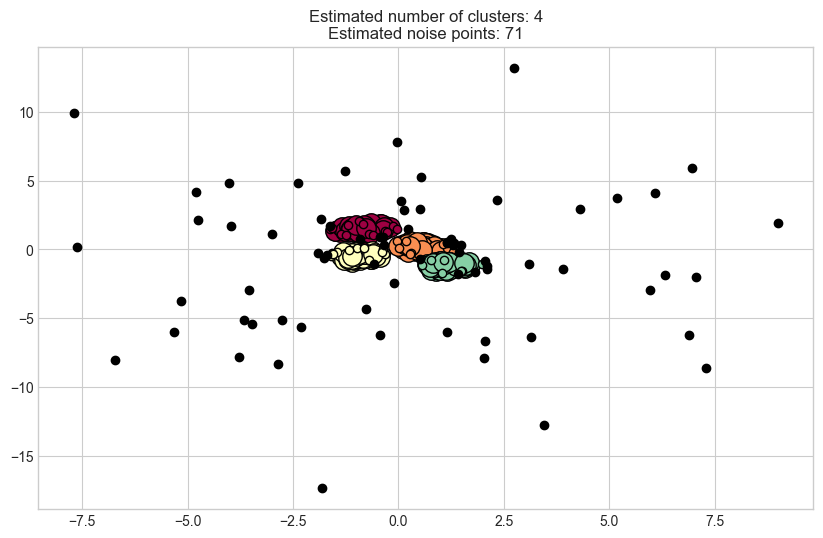

In [16]:
# Display a simple illustration of how DBSCAN works
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Create sample data with obvious clusters
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
X = StandardScaler().fit_transform(X)

# Add some noise points
X = np.vstack([X, np.random.randn(50, 2) * 5])

# Apply DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Plot results
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10, 6))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    # Plot core samples
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)
    
    # Plot non-core samples
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'Estimated number of clusters: {n_clusters_}\nEstimated noise points: {n_noise_}')
plt.show()

## DBSCAN Parameters Explained

DBSCAN requires two main parameters:

- eps (ε): The maximum distance between two samples for them to be considered neighbors
- min_samples: The minimum number of samples in a neighborhood for a point to be considered a core point

Core concepts:

- Core point: A point with at least min_samples points within distance eps
- Border point: A point with fewer than min_samples points within distance eps, but in the neighborhood of a core point
- Noise/Outlier: A point that is neither a core point nor a border point

In [17]:
# Set random seed for reproducibility
np.random.seed(42)

# Create date range for one year of daily data
date_rng = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
n_days = len(date_rng)

# Create product categories
categories = ['Electronics', 'Clothing', 'Groceries', 'Home Goods', 'Beauty']

# Create base sales patterns with seasonal effects
def create_sales_with_seasonality(n_days, base_sales, weekly_pattern, monthly_pattern, 
                                 trend=0, noise_level=1, seasonal_amplitude=0.2):
    # Time components
    days = np.arange(n_days)
    
    # Weekly seasonality (weekends have higher sales)
    weekly = weekly_pattern[np.remainder(days, 7)]
    
    # Monthly seasonality (sales spike at beginning/end of month)
    monthly = monthly_pattern[np.minimum(days % 30, 29)]
    
    # Annual seasonality (higher in summer and holiday season)
    annual = seasonal_amplitude * np.sin(2 * np.pi * days / 365)
    annual += seasonal_amplitude * 0.8 * np.exp(-((days - 350) ** 2) / 200)  # Holiday spike
    
    # Trend component
    trend_component = trend * days / n_days
    
    # Combine components
    sales = base_sales + trend_component + weekly + monthly + annual
    
    # Add random noise
    sales += np.random.normal(0, noise_level, n_days)
    
    # Ensure no negative sales
    return np.maximum(sales, 0)

# Define weekly patterns (weekends vs weekdays)
electronics_weekly = np.array([0.8, 0.7, 0.6, 0.7, 0.9, 2.0, 1.8])
clothing_weekly = np.array([0.9, 0.8, 0.7, 0.8, 1.0, 1.9, 1.7])
groceries_weekly = np.array([0.7, 0.8, 0.9, 1.0, 1.2, 1.8, 1.5])
home_goods_weekly = np.array([0.6, 0.6, 0.7, 0.8, 1.0, 2.2, 1.9])
beauty_weekly = np.array([0.7, 0.8, 0.9, 0.9, 1.1, 1.7, 1.6])

# Define monthly patterns (beginning/end of month spikes)
monthly_pattern = np.sin(np.linspace(0, 2*np.pi, 30)) * 0.5 + 1

# Generate sales data for each category
electronics_sales = create_sales_with_seasonality(n_days, 50, electronics_weekly, 
                                                monthly_pattern, trend=20, noise_level=8)
clothing_sales = create_sales_with_seasonality(n_days, 80, clothing_weekly, 
                                              monthly_pattern, trend=10, noise_level=12)
groceries_sales = create_sales_with_seasonality(n_days, 120, groceries_weekly, 
                                               monthly_pattern, trend=5, noise_level=15)
home_goods_sales = create_sales_with_seasonality(n_days, 60, home_goods_weekly, 
                                                monthly_pattern, trend=15, noise_level=10)
beauty_sales = create_sales_with_seasonality(n_days, 45, beauty_weekly, 
                                            monthly_pattern, trend=8, noise_level=7)

# Create customer count (correlated with total sales but with some variation)
total_sales = electronics_sales + clothing_sales + groceries_sales + home_goods_sales + beauty_sales
customer_count = (total_sales / np.mean(total_sales) * 1000) + np.random.normal(0, 50, n_days)
customer_count = np.maximum(customer_count, 0).astype(int)

# Calculate average transaction value
avg_transaction = total_sales / customer_count
avg_transaction = np.nan_to_num(avg_transaction, nan=0)

# Create dataframe
data = {
    'date': date_rng,
    'day_of_week': date_rng.dayofweek,
    'month': date_rng.month,
    'day': date_rng.day,
    'is_weekend': (date_rng.dayofweek >= 5).astype(int),
    'electronics_sales': electronics_sales,
    'clothing_sales': clothing_sales,
    'groceries_sales': groceries_sales,
    'home_goods_sales': home_goods_sales,
    'beauty_sales': beauty_sales,
    'total_sales': total_sales,
    'customer_count': customer_count,
    'avg_transaction': avg_transaction
}

df = pd.DataFrame(data)

# Add some special events (like Black Friday, major sales) that create outliers
special_events = ['2024-01-01', '2024-07-04', '2024-11-29', '2024-12-24', '2024-12-26']
for event in special_events:
    idx = df[df['date'] == event].index
    if len(idx) > 0:
        boost_factor = np.random.uniform(1.5, 3.0)
        df.loc[idx, 'electronics_sales'] *= boost_factor
        df.loc[idx, 'clothing_sales'] *= boost_factor
        df.loc[idx, 'groceries_sales'] *= boost_factor
        df.loc[idx, 'home_goods_sales'] *= boost_factor
        df.loc[idx, 'beauty_sales'] *= boost_factor
        df.loc[idx, 'total_sales'] = (df.loc[idx, 'electronics_sales'] + 
                                    df.loc[idx, 'clothing_sales'] + 
                                    df.loc[idx, 'groceries_sales'] + 
                                    df.loc[idx, 'home_goods_sales'] + 
                                    df.loc[idx, 'beauty_sales'])
        df.loc[idx, 'customer_count'] = (df.loc[idx, 'total_sales'] / 
                                       df.loc[idx, 'total_sales'].mean() * 1000).astype(int)

# Display the first few rows
print("Generated retail time series data:")
df.head()

# Basic statistics
print("\nBasic statistics of the dataset:")
df.describe()

Generated retail time series data:

Basic statistics of the dataset:


,date,day_of_week,month,day,is_weekend,electronics_sales,clothing_sales,groceries_sales,home_goods_sales,beauty_sales,total_sales,customer_count,avg_transaction
count,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2024-07-01 12:00:00.000000256,2.986339,6.513661,15.756831,0.284153,63.644248,88.653572,129.314749,72.242883,52.577703,406.433154,998.409836,0.398391
min,2024-01-01 00:00:00,0.000000,1.000000,1.000000,0.000000,35.231061,56.545151,83.367876,33.273308,29.371675,299.560187,714.000000,0.338682
25%,2024-04-01 06:00:00,1.000000,4.000000,8.000000,0.000000,55.143383,77.500945,116.373606,63.076051,46.547214,375.521205,939.250000,0.384796
50%,2024-07-01 12:00:00,3.000000,7.000000,16.000000,0.000000,62.510735,86.756646,126.611342,70.609367,51.666878,397.075017,996.500000,0.397514
75%,2024-09-30 18:00:00,5.000000,9.750000,23.000000,1.000000,69.039911,95.268293,136.925285,78.419316,56.499971,418.131286,1056.750000,0.409965
max,2024-12-31 00:00:00,6.000000,12.000000,31.000000,1.000000,220.435456,268.047504,402.090617,261.033714,163.356322,1314.963613,1228.000000,0.469626
std,NaN,2.006108,3.455958,8.823592,0.451627,17.191412,21.955503,28.981579,20.701360,12.626171,89.557814,85.677262,0.019977


## Data Exploration and Visualization

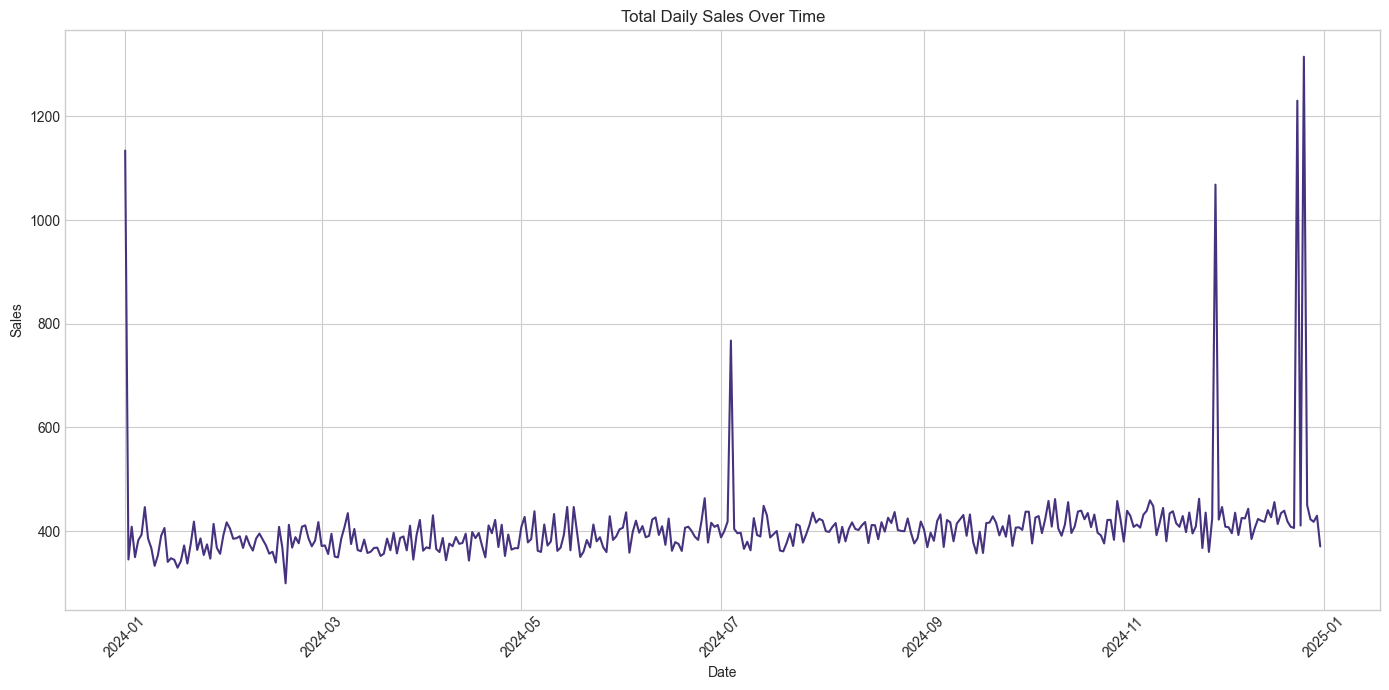

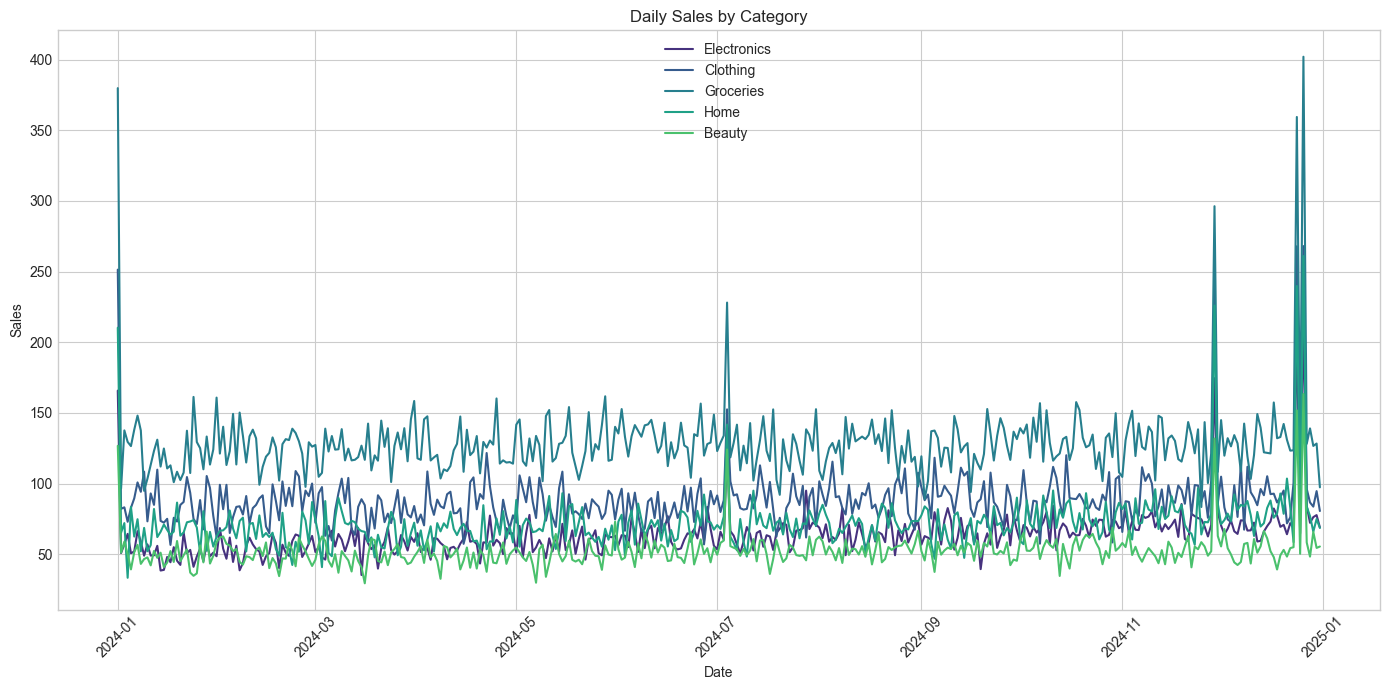

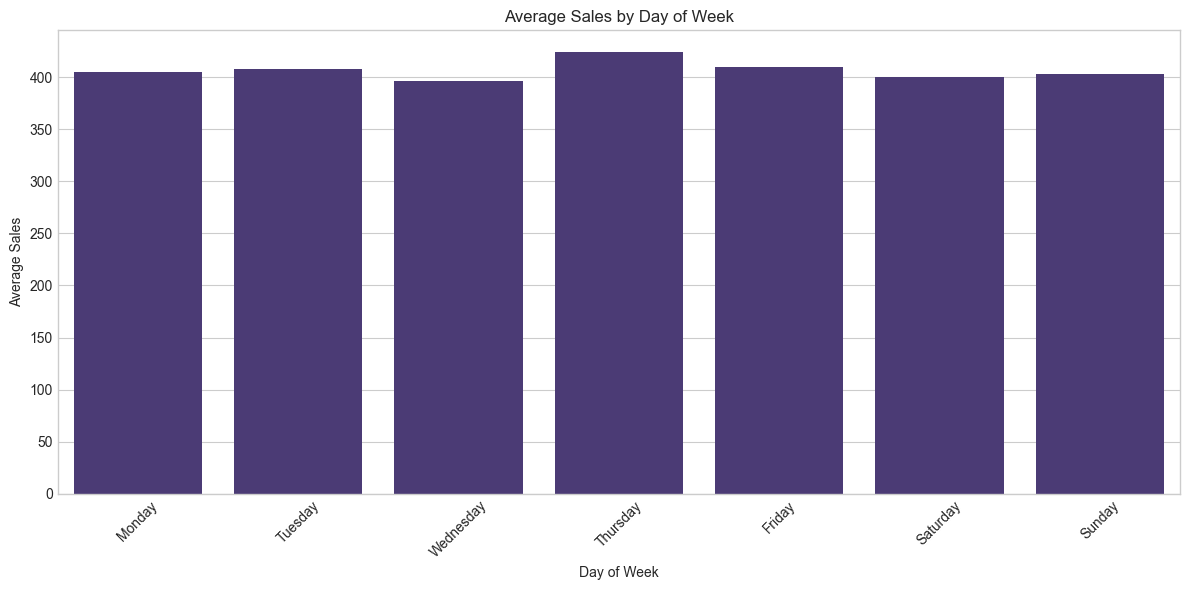

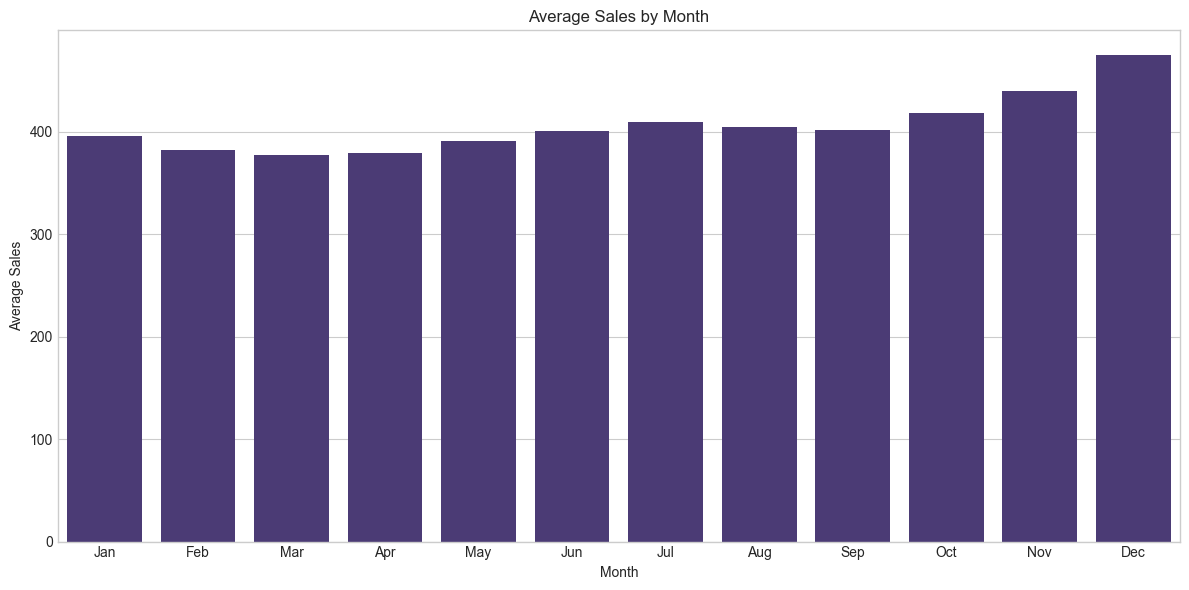

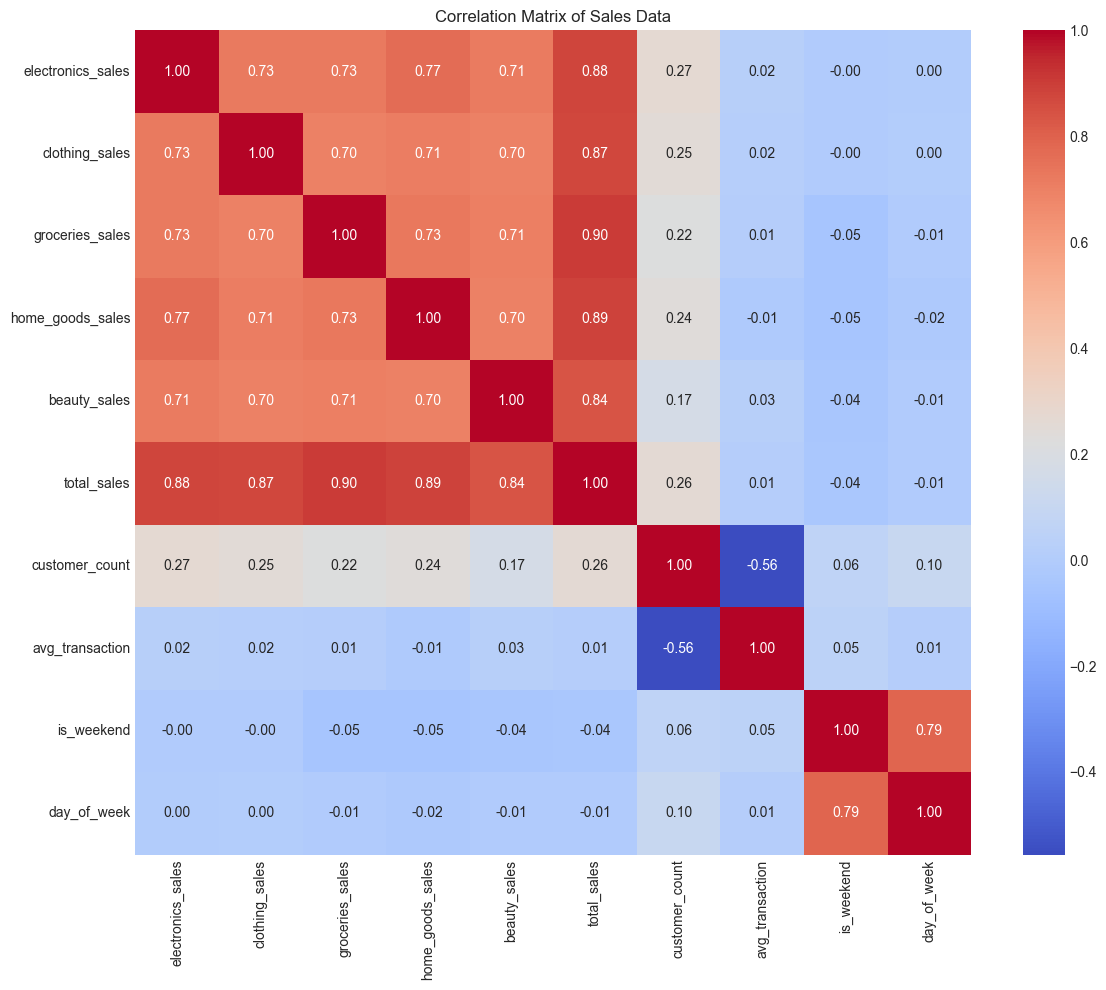

In [18]:
# Plot time series of total sales
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['total_sales'])
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot sales by category
plt.figure(figsize=(14, 7))
for category in ['electronics_sales', 'clothing_sales', 'groceries_sales', 
                'home_goods_sales', 'beauty_sales']:
    plt.plot(df['date'], df[category], label=category.split('_')[0].capitalize())
plt.title('Daily Sales by Category')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot sales by day of week
plt.figure(figsize=(12, 6))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg_sales = df.groupby('day_of_week')['total_sales'].mean()
sns.barplot(x=[day_names[i] for i in range(7)], y=day_avg_sales.values)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot sales by month
plt.figure(figsize=(12, 6))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_avg_sales = df.groupby('month')['total_sales'].mean()
sns.barplot(x=[month_names[i-1] for i in range(1, 13)], y=month_avg_sales.values)
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

# Analyze correlation between variables
plt.figure(figsize=(12, 10))
correlation_columns = ['electronics_sales', 'clothing_sales', 'groceries_sales', 
                      'home_goods_sales', 'beauty_sales', 'total_sales', 
                      'customer_count', 'avg_transaction', 'is_weekend', 'day_of_week']
correlation_matrix = df[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Sales Data')
plt.tight_layout()
plt.show()

## Feature Engineering for Clustering

In [19]:
# Select features for clustering
features = [
    'electronics_sales', 'clothing_sales', 'groceries_sales', 
    'home_goods_sales', 'beauty_sales', 'customer_count', 
    'avg_transaction', 'day_of_week', 'is_weekend', 'month'
]

# Extract features from dataframe
X = df[features].copy()

# Standardize the features (important for distance-based algorithms like DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a dataframe of scaled features for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

print("Scaled features (first 5 rows):")
X_scaled_df.head()

Scaled features (first 5 rows):


,electronics_sales,clothing_sales,groceries_sales,home_goods_sales,beauty_sales,customer_count,avg_transaction,day_of_week,is_weekend,month
0,5.947271,7.421752,8.656903,6.677728,5.878981,0.018585,-0.765539,-1.490661,-0.630037,-1.597591
1,-0.750516,-0.299387,-1.137757,-0.339867,-0.120936,-1.372249,-0.311687,-0.991501,-0.630037,-1.597591
2,-0.380746,-0.251305,0.285632,-0.012770,0.497440,0.906849,-0.932048,-0.492341,-0.630037,-1.597591
3,0.041754,-0.717649,0.004426,-1.885041,-0.201169,-1.208622,-0.365314,0.006819,-0.630037,-1.597591
4,-0.757463,-0.267055,-0.097603,0.541750,-1.060093,-0.776177,0.606771,0.505979,-0.630037,-1.597591


## Finding Optimal DBSCAN Parameters

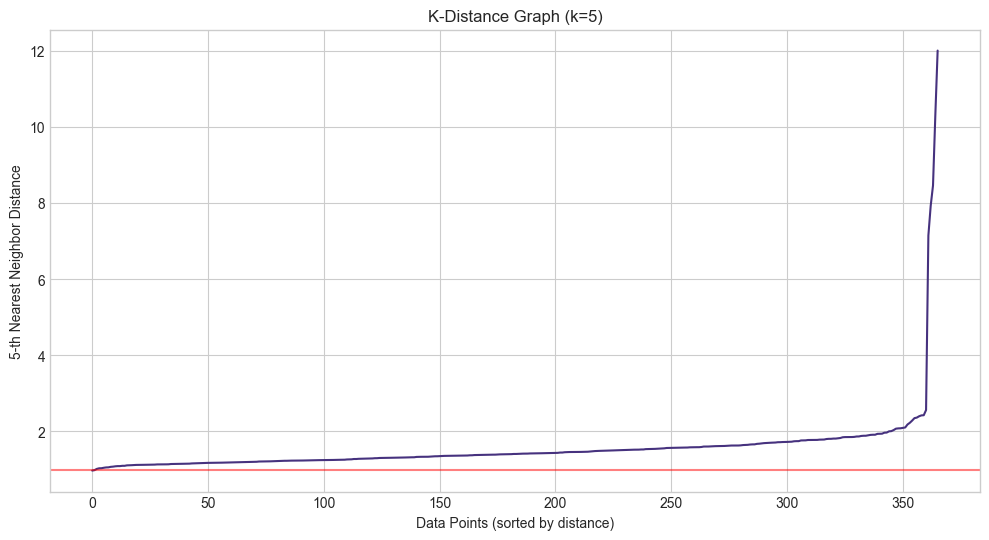

DBSCAN parameter evaluation results:


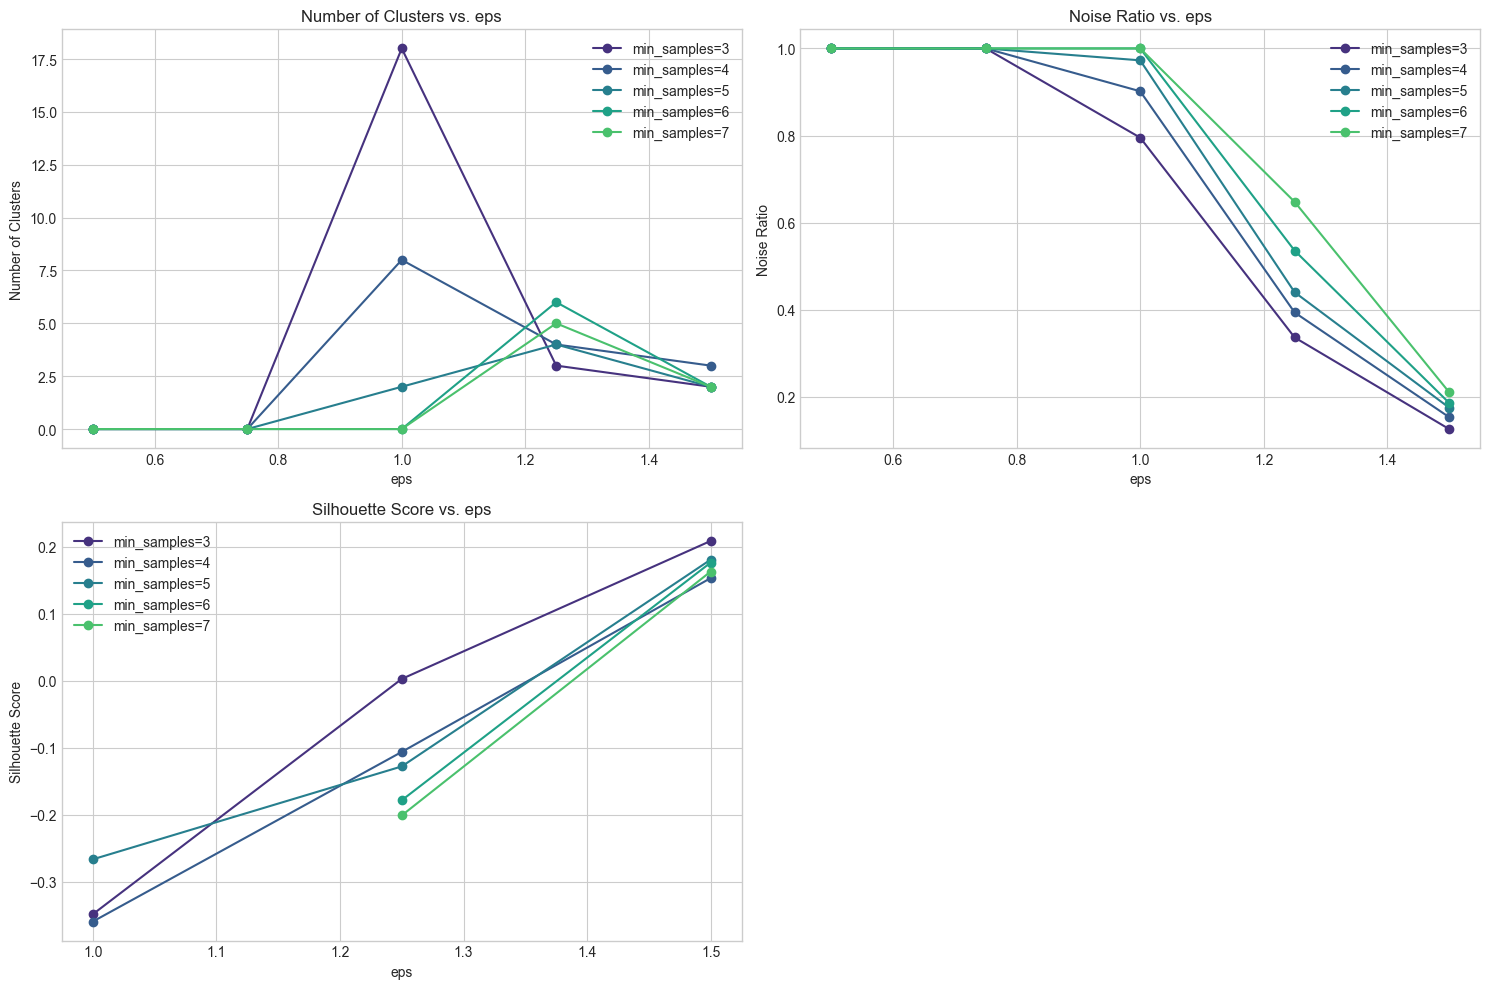

Best parameters based on silhouette score: eps=1.5, min_samples=3.0


In [20]:
# Function to determine optimal eps value using k-distance graph
def find_optimal_eps(X, k):
    # Calculate distances
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, indices = neigh.kneighbors(X)
    
    # Sort distances
    distances = np.sort(distances[:, k-1])
    
    # Plot k-distance graph
    plt.figure(figsize=(12, 6))
    plt.plot(distances)
    plt.xlabel('Data Points (sorted by distance)')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title(f'K-Distance Graph (k={k})')
    plt.grid(True)
    
    # Add a horizontal line at the elbow point
    # Look for the "elbow" in this plot to determine eps
    plt.axhline(y=1.0, color='r', linestyle='-', alpha=0.5)
    plt.show()
    
    return distances

# Find optimal eps value using k-distance plot
k = 5  # min_samples will be k-1
distances = find_optimal_eps(X_scaled, k)

# Based on the k-distance plot, choose an eps value where there's an "elbow"
# This is where we see a sharp change in the distance graph
# For demonstration, let's choose eps values to test
eps_values = [0.5, 0.75, 1.0, 1.25, 1.5]
min_samples_values = [3, 4, 5, 6, 7]

# We'll evaluate different combinations of parameters
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)
        
        # Count number of clusters and noise points
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        
        # Calculate silhouette score if more than one cluster and not all points are noise
        if n_clusters > 1 and n_noise < len(X_scaled):
            try:
                silhouette = silhouette_score(X_scaled, clusters)
            except:
                silhouette = np.nan
        else:
            silhouette = np.nan
        
        # Store results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(X_scaled),
            'silhouette': silhouette
        })

# Convert results to dataframe
results_df = pd.DataFrame(results)
print("DBSCAN parameter evaluation results:")
results_df

# Visualize parameter search results
plt.figure(figsize=(15, 10))

# Plot 1: Number of clusters
plt.subplot(2, 2, 1)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['n_clusters'], 'o-', label=f'min_samples={min_samples}')
plt.xlabel('eps')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. eps')
plt.legend()
plt.grid(True)

# Plot 2: Noise ratio
plt.subplot(2, 2, 2)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['noise_ratio'], 'o-', label=f'min_samples={min_samples}')
plt.xlabel('eps')
plt.ylabel('Noise Ratio')
plt.title('Noise Ratio vs. eps')
plt.legend()
plt.grid(True)

# Plot 3: Silhouette score
plt.subplot(2, 2, 3)
for min_samples in min_samples_values:
    subset = results_df[results_df['min_samples'] == min_samples]
    plt.plot(subset['eps'], subset['silhouette'], 'o-', label=f'min_samples={min_samples}')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. eps')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Choose optimal parameters based on our evaluation
# Find parameters with highest silhouette score
best_params = results_df.loc[results_df['silhouette'].idxmax()]
print(f"Best parameters based on silhouette score: eps={best_params['eps']}, min_samples={best_params['min_samples']}")

## Applying DBSCAN with Optimal Parameters

In [21]:
# Apply DBSCAN with optimal parameters
optimal_eps = best_params['eps']  # Use value from our parameter search
optimal_min_samples = int(best_params['min_samples'])  # Use value from our parameter search

# Fallback in case silhouette score doesn't work well
if np.isnan(best_params['silhouette']):
    optimal_eps = 1.0
    optimal_min_samples = 5
    print(f"Using fallback parameters: eps={optimal_eps}, min_samples={optimal_min_samples}")

# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = clusters

# Analyze the results
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(df)*100:.2f}%)")

# Examine cluster distribution
cluster_counts = df['cluster'].value_counts().sort_index()
print("\nCluster distribution:")
print(cluster_counts)

# Calculate cluster centroids in the original feature space
cluster_centroids = {}
for cluster in sorted(df['cluster'].unique()):
    if cluster != -1:  # Skip noise points
        cluster_data = df[df['cluster'] == cluster][features]
        cluster_centroids[cluster] = cluster_data.mean()

# Convert centroids to dataframe
centroids_df = pd.DataFrame(cluster_centroids).T
print("\nCluster centroids (in original feature space):")
centroids_df

Number of clusters: 2
Number of noise points: 46 (12.57%)

Cluster distribution:
cluster
-1     46
 0    235
 1     85
Name: count, dtype: int64

Cluster centroids (in original feature space):


,electronics_sales,clothing_sales,groceries_sales,home_goods_sales,beauty_sales,customer_count,avg_transaction,day_of_week,is_weekend,month
0,61.475024,85.484495,126.130972,70.279390,51.270901,994.825532,0.397361,2.017021,0.0,6.497872
1,62.999890,88.981225,127.170578,70.728908,52.509395,1011.905882,0.398333,5.482353,1.0,6.752941


## Visualizing the Clusters

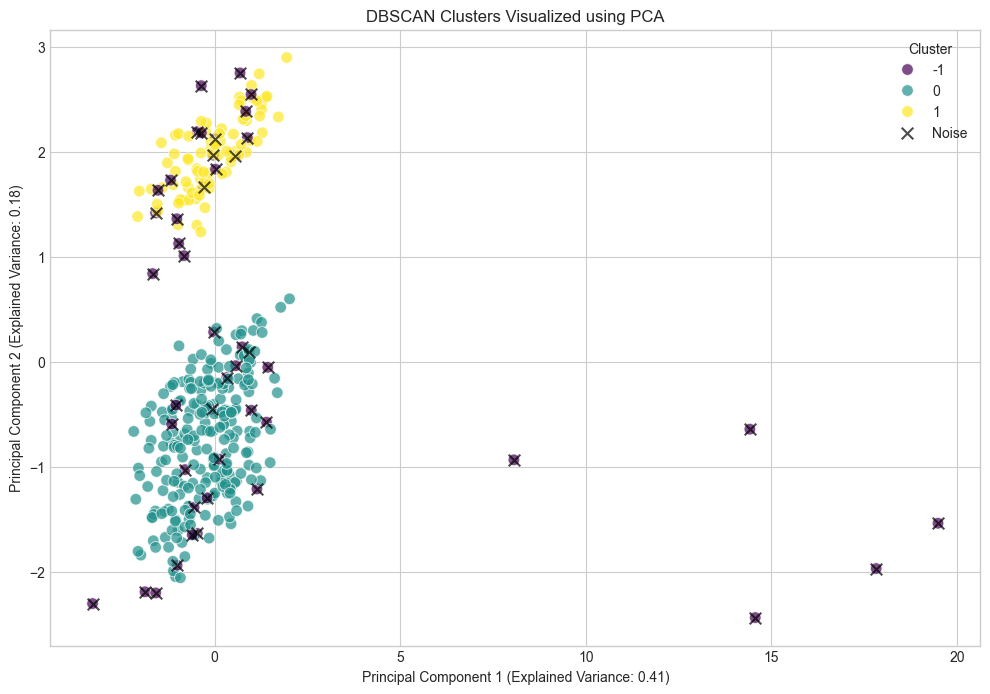

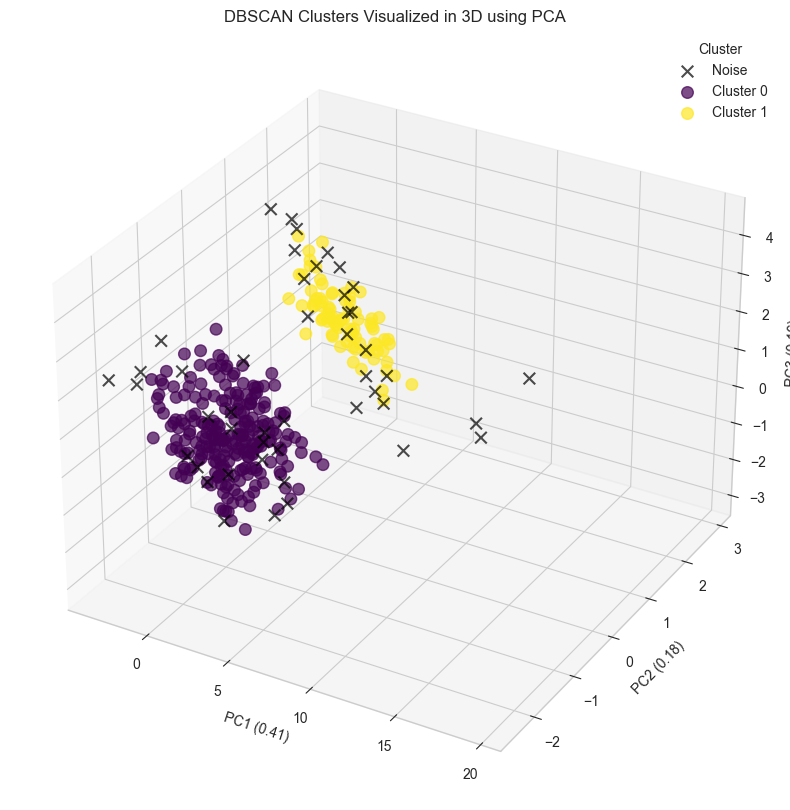

In [22]:
# Use PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for the 2D data
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': clusters
})

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', 
                palette='viridis', data=pca_df, 
                alpha=0.7, s=70, legend='full')

# Add a special marker for noise points
noise_points = pca_df[pca_df['Cluster'] == -1]
plt.scatter(noise_points['PCA1'], noise_points['PCA2'], 
            color='black', marker='x', alpha=0.7, s=70, label='Noise')

plt.title('DBSCAN Clusters Visualized using PCA')
plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Use PCA to reduce to 3 dimensions for better visualization
pca3d = PCA(n_components=3)
X_pca3d = pca3d.fit_transform(X_scaled)

# Create a DataFrame for the 3D data
pca3d_df = pd.DataFrame({
    'PCA1': X_pca3d[:, 0],
    'PCA2': X_pca3d[:, 1],
    'PCA3': X_pca3d[:, 2],
    'Cluster': clusters
})

# Plot the clusters in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a colormap that handles noise points specially
unique_clusters = sorted(pca3d_df['Cluster'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters) - (1 if -1 in unique_clusters else 0)))
color_dict = {}
color_index = 0

for cluster in unique_clusters:
    if cluster == -1:
        color_dict[cluster] = 'black'
    else:
        color_dict[cluster] = colors[color_index]
        color_index += 1

# Plot each cluster
for cluster in unique_clusters:
    cluster_data = pca3d_df[pca3d_df['Cluster'] == cluster]
    marker = 'x' if cluster == -1 else 'o'
    ax.scatter(cluster_data['PCA1'], cluster_data['PCA2'], cluster_data['PCA3'],
               color=color_dict[cluster], marker=marker, s=70, alpha=0.7,
               label=f'Cluster {cluster}' if cluster != -1 else 'Noise')

ax.set_title('DBSCAN Clusters Visualized in 3D using PCA')
ax.set_xlabel(f'PC1 ({pca3d.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca3d.explained_variance_ratio_[1]:.2f})')
ax.set_zlabel(f'PC3 ({pca3d.explained_variance_ratio_[2]:.2f})')
ax.legend(title='Cluster')
plt.show()

## Analyzing Cluster Characteristics

Cluster means for each feature:


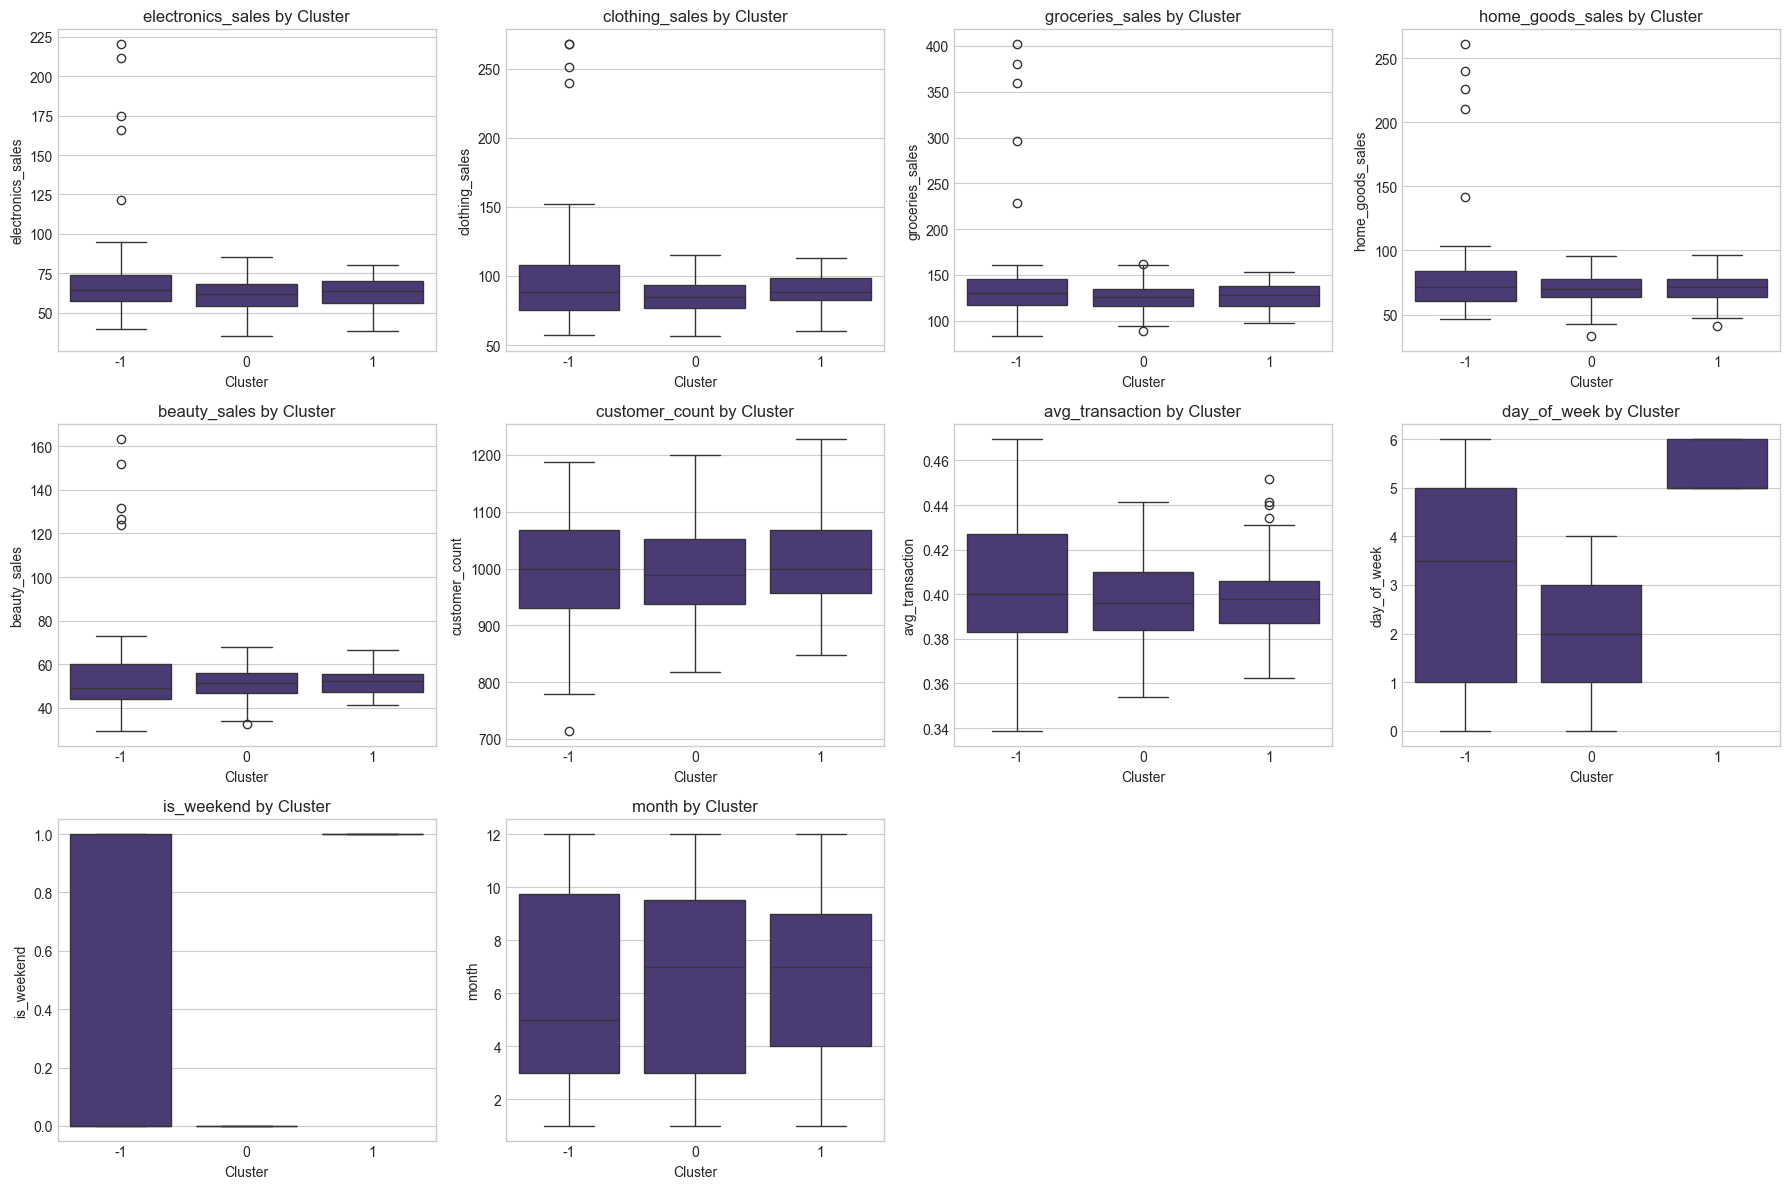

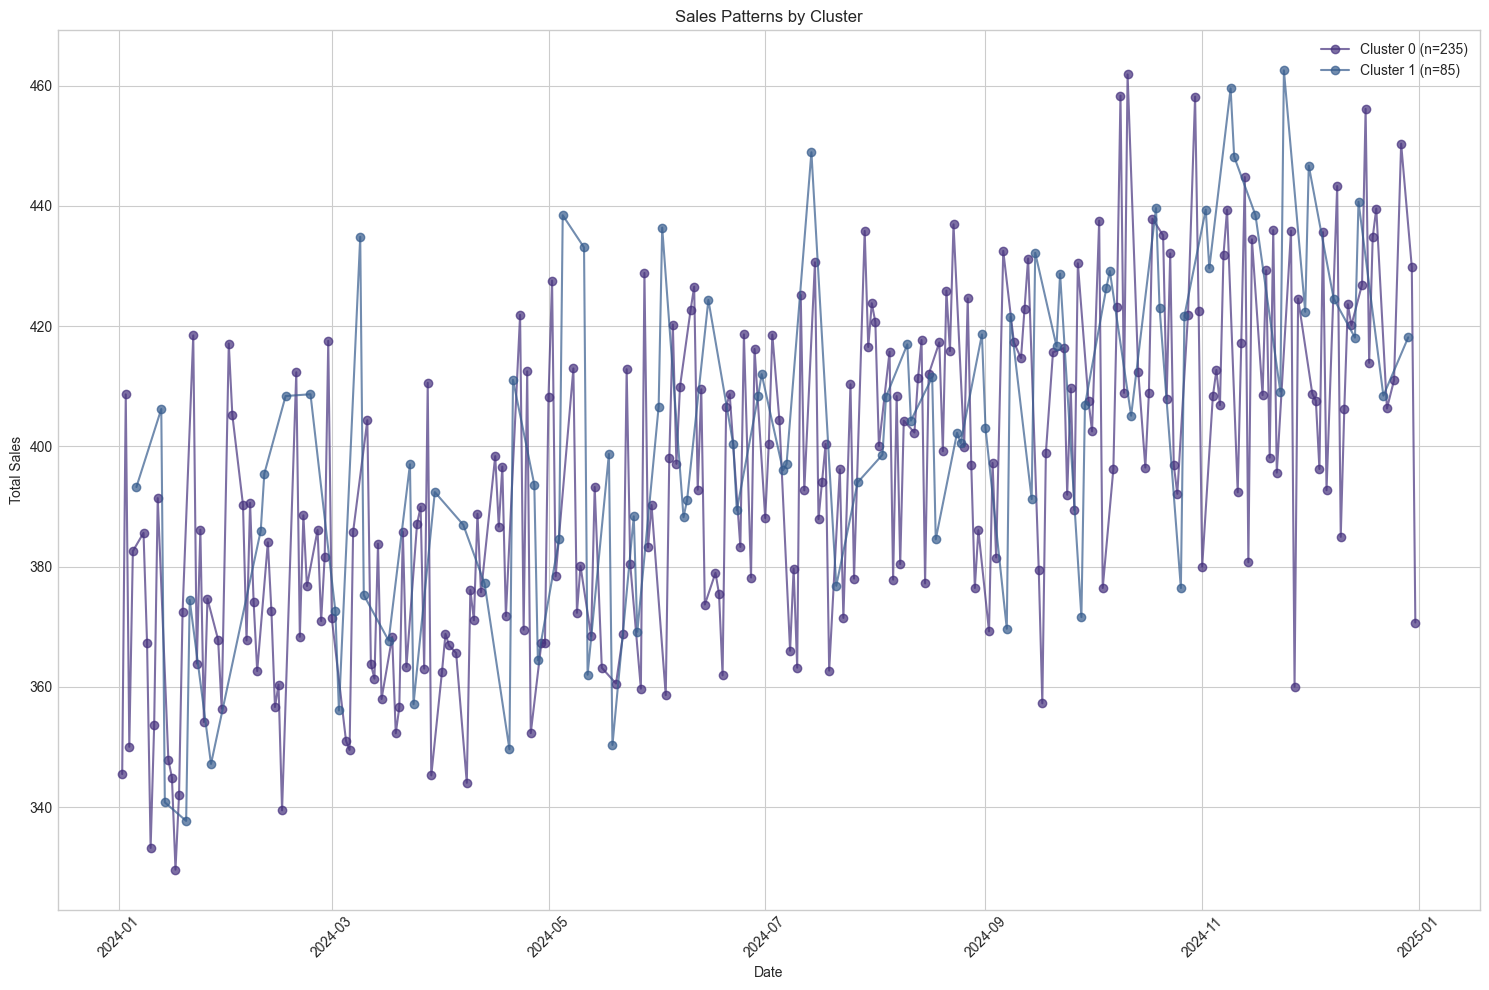

<Figure size 1400x800 with 0 Axes>

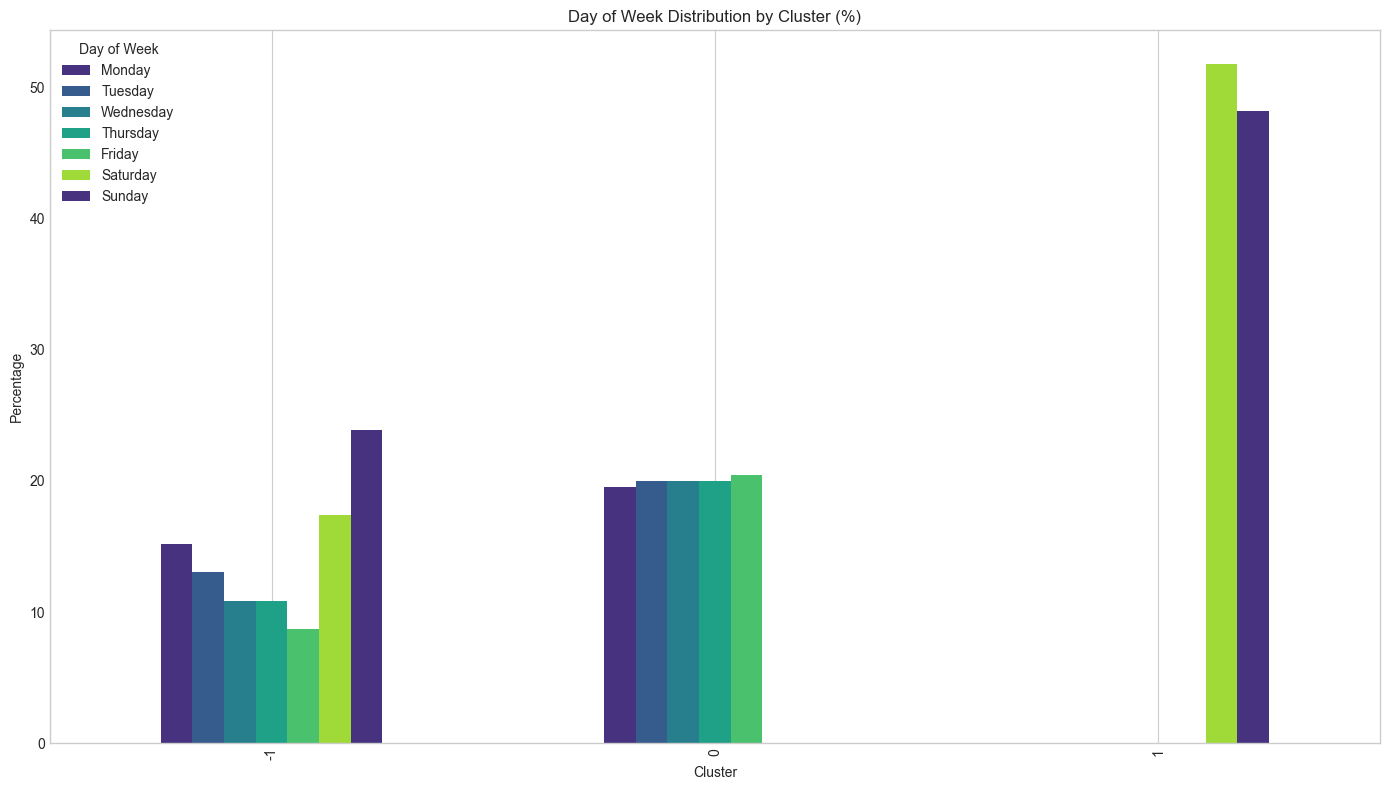

<Figure size 1400x800 with 0 Axes>

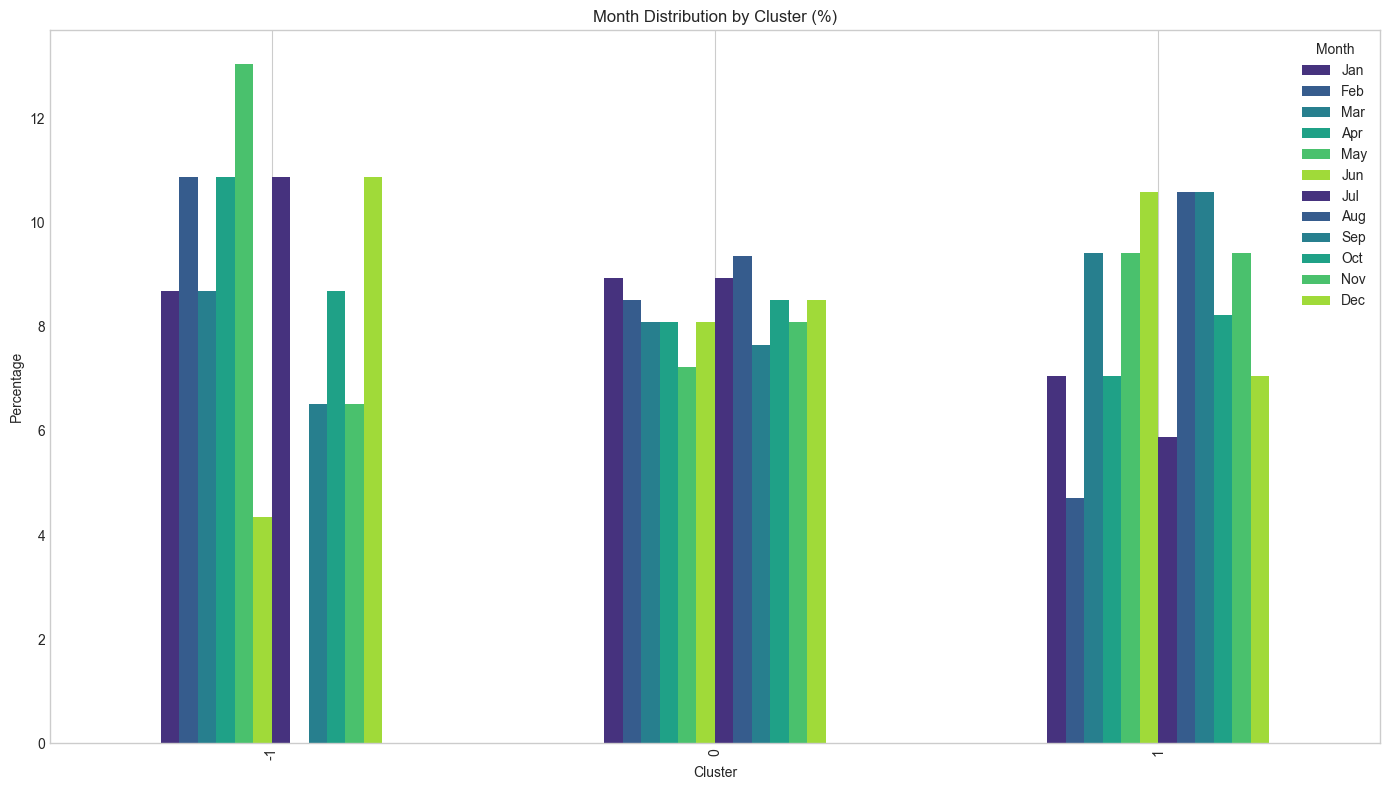

In [23]:
# Analyze each cluster in terms of original features
cluster_summary = df.groupby('cluster')[features].mean()
print("Cluster means for each feature:")
cluster_summary

# Visualize feature distribution across clusters
plt.figure(figsize=(18, 12))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    
    # For each cluster, create boxplot
    sns.boxplot(x='cluster', y=feature, data=df)
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    
plt.tight_layout()
plt.show()

# Visualize sales patterns by cluster
plt.figure(figsize=(15, 10))
for cluster in sorted(df['cluster'].unique()):
    if cluster == -1:
        continue  # Skip noise points for clarity
        
    cluster_data = df[df['cluster'] == cluster]
    plt.plot(cluster_data['date'], cluster_data['total_sales'], 'o-', alpha=0.7, 
             label=f'Cluster {cluster} (n={len(cluster_data)})')

plt.title('Sales Patterns by Cluster')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize day of week distribution by cluster
plt.figure(figsize=(14, 8))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a grouped bar chart
cluster_day_counts = pd.crosstab(df['cluster'], df['day_of_week'])
cluster_day_counts.columns = day_names

# Convert to percentages
cluster_day_pcts = cluster_day_counts.div(cluster_day_counts.sum(axis=1), axis=0) * 100

# Plot
cluster_day_pcts.plot(kind='bar', figsize=(14, 8))
plt.title('Day of Week Distribution by Cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Day of Week')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Visualize month distribution by cluster
plt.figure(figsize=(14, 8))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a grouped bar chart
cluster_month_counts = pd.crosstab(df['cluster'], df['month'])
cluster_month_counts.columns = month_names

# Convert to percentages
cluster_month_pcts = cluster_month_counts.div(cluster_month_counts.sum(axis=1), axis=0) * 100

# Plot
cluster_month_pcts.plot(kind='bar', figsize=(14, 8))
plt.title('Month Distribution by Cluster (%)')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Month')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Identifying Outliers and Special Events

Number of noise points: 46

Noise points with holiday information:


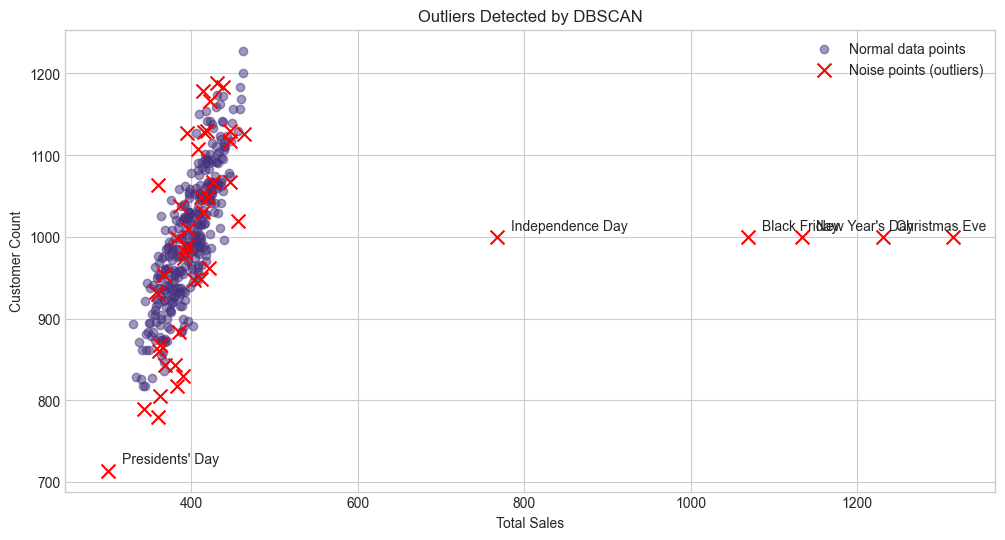

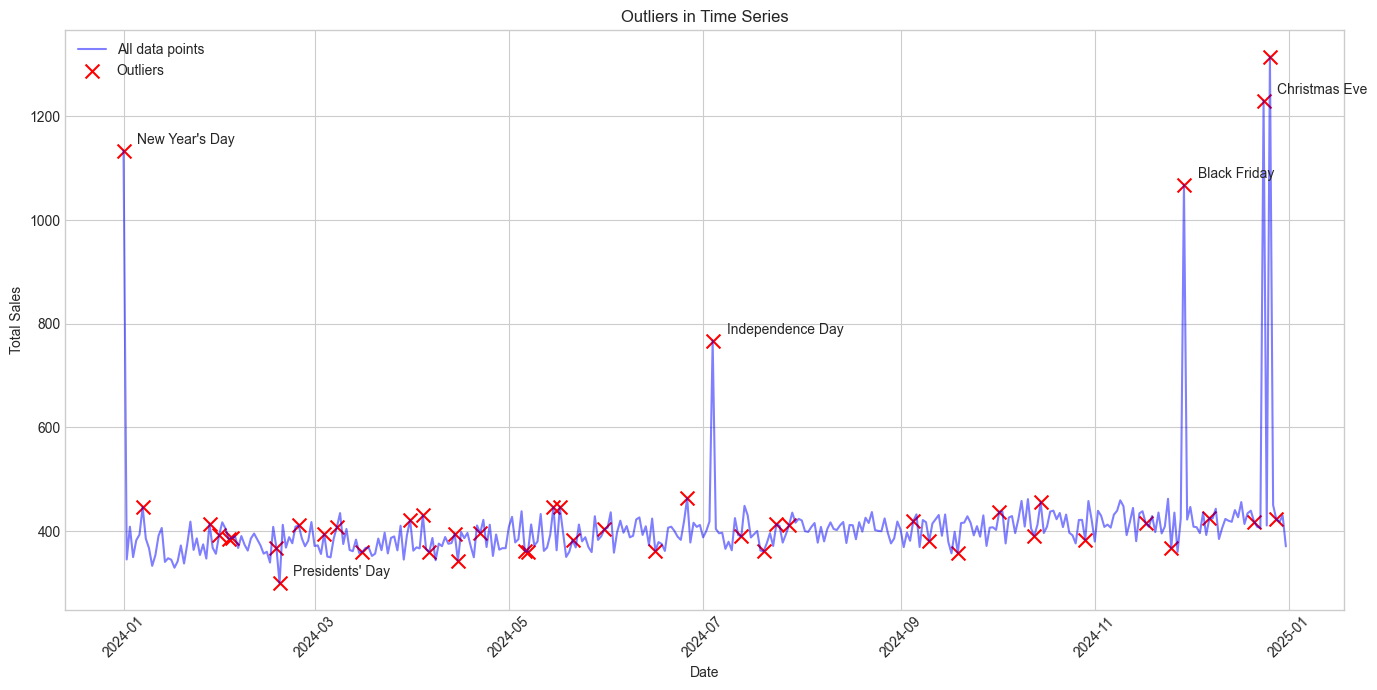

In [24]:
# Analyze noise points (outliers)
noise_points = df[df['cluster'] == -1]
print(f"Number of noise points: {len(noise_points)}")

# Check if noise points correspond to special events or holidays
# Convert dates to datetime if not already
noise_points['date'] = pd.to_datetime(noise_points['date'])

# Function to check if a date is a holiday or special event
def is_special_event(date):
    # List of major US holidays and events
    holidays = {
        '2024-01-01': 'New Year\'s Day',
        '2024-01-15': 'Martin Luther King Jr. Day',
        '2024-02-14': 'Valentine\'s Day',
        '2024-02-19': 'Presidents\' Day',
        '2024-04-07': 'Easter',
        '2024-05-27': 'Memorial Day',
        '2024-06-19': 'Juneteenth',
        '2024-07-04': 'Independence Day',
        '2024-09-02': 'Labor Day',
        '2024-10-31': 'Halloween',
        '2024-11-11': 'Veterans Day',
        '2024-11-28': 'Thanksgiving',
        '2024-11-29': 'Black Friday',
        '2024-12-24': 'Christmas Eve',
        '2024-12-25': 'Christmas Day',
        '2024-12-31': 'New Year\'s Eve'
    }
    
    date_str = date.strftime('%Y-%m-%d')
    if date_str in holidays:
        return holidays[date_str]
    return None

# Add holiday information to noise points
noise_points['special_event'] = noise_points['date'].apply(is_special_event)

# Display noise points with date information
print("\nNoise points with holiday information:")
noise_points_display = noise_points[['date', 'total_sales', 'customer_count', 'special_event']]
noise_points_display = noise_points_display.sort_values('total_sales', ascending=False)
noise_points_display.head(10)

# Compare noise points with regular points
plt.figure(figsize=(12, 6))
plt.scatter(df[df['cluster'] != -1]['total_sales'], df[df['cluster'] != -1]['customer_count'], 
           alpha=0.5, label='Normal data points')
plt.scatter(noise_points['total_sales'], noise_points['customer_count'], 
           color='red', marker='x', s=100, label='Noise points (outliers)')

# Annotate special events
for idx, row in noise_points.iterrows():
    if pd.notna(row['special_event']):
        plt.annotate(row['special_event'], 
                    (row['total_sales'], row['customer_count']),
                    xytext=(10, 5), textcoords='offset points')

plt.title('Outliers Detected by DBSCAN')
plt.xlabel('Total Sales')
plt.ylabel('Customer Count')
plt.legend()
plt.grid(True)
plt.show()

# Visualize outliers in time series
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['total_sales'], 'b-', alpha=0.5, label='All data points')
plt.scatter(noise_points['date'], noise_points['total_sales'], 
           color='red', marker='x', s=100, label='Outliers')

# Annotate special events
for idx, row in noise_points.iterrows():
    if pd.notna(row['special_event']):
        plt.annotate(row['special_event'], 
                    (row['date'], row['total_sales']),
                    xytext=(10, 5), textcoords='offset points')

plt.title('Outliers in Time Series')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Interpreting Cluster Results for Business Insights


CLUSTER 0 PROFILE
Size: 235 days (64.21% of total)
Average Sales: $394.64
Average Customer Count: 995
Average Transaction Value: $0.40
Dominant Product Category: Groceries

Sales by Category:
  - Electronics: $61.48
  - Clothing: $85.48
  - Groceries: $126.13
  - Home Goods: $70.28
  - Beauty: $51.27

Day of Week Distribution:
Mon    0.195745
Tue    0.200000
Wed    0.200000
Thu    0.200000
Fri    0.204255
Sat    0.000000
Sun    0.000000
Name: proportion, dtype: float64

Month Distribution:
  - Jan: 8.94%
  - Feb: 8.51%
  - Mar: 8.09%
  - Apr: 8.09%
  - May: 7.23%
  - Jun: 8.09%
  - Jul: 8.94%
  - Aug: 9.36%
  - Sep: 7.66%
  - Oct: 8.51%
  - Nov: 8.09%
  - Dec: 8.51%

Business Interpretation:
  - Weekday-dominant cluster
  - Low average transaction value

CLUSTER 1 PROFILE
Size: 85 days (23.22% of total)
Average Sales: $402.39
Average Customer Count: 1012
Average Transaction Value: $0.40
Dominant Product Category: Groceries

Sales by Category:
  - Electronics: $63.00
  - Clothing: $88.

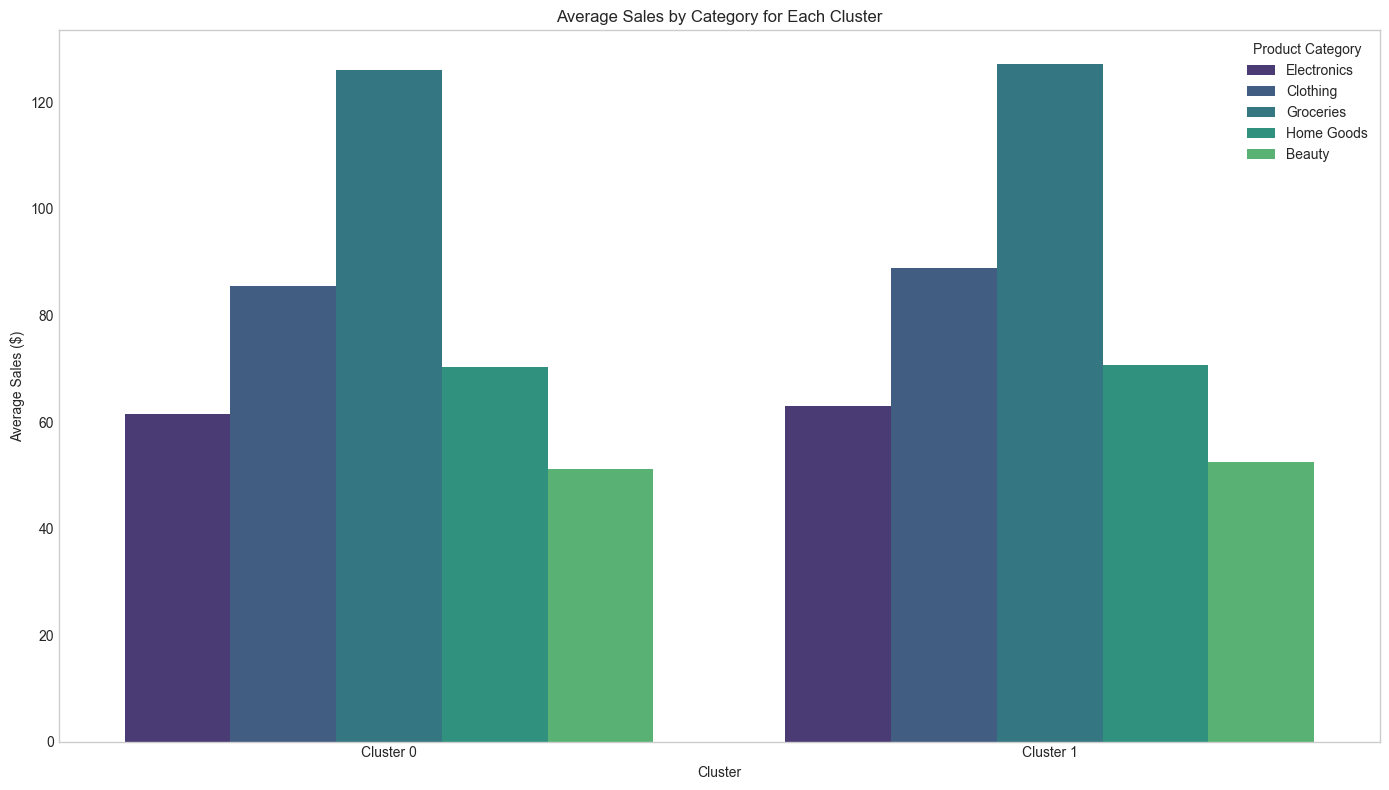

In [25]:
# Create more detailed cluster profiles
cluster_profiles = {}

for cluster in sorted(df['cluster'].unique()):
    if cluster == -1:
        continue  # Skip noise points
        
    cluster_data = df[df['cluster'] == cluster]
    
    # Basic stats
    size = len(cluster_data)
    pct = size / len(df) * 100
    
    # Day of week distribution
    dow_dist = cluster_data['day_of_week'].value_counts(normalize=True)
    # Create a Series with all days of the week and fill missing values with 0
    dow_dist = dow_dist.reindex(range(7), fill_value=0).sort_index()
    dow_dist.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    # Month distribution
    month_dist = cluster_data['month'].value_counts(normalize=True).sort_index()
    
    # Sales metrics
    avg_sales = cluster_data['total_sales'].mean()
    avg_customers = cluster_data['customer_count'].mean()
    avg_transaction_value = cluster_data['avg_transaction'].mean()
    
    # Sales by category
    category_sales = {
        'Electronics': cluster_data['electronics_sales'].mean(),
        'Clothing': cluster_data['clothing_sales'].mean(),
        'Groceries': cluster_data['groceries_sales'].mean(),
        'Home Goods': cluster_data['home_goods_sales'].mean(),
        'Beauty': cluster_data['beauty_sales'].mean()
    }
    
    # Most dominant category
    dominant_category = max(category_sales.items(), key=lambda x: x[1])[0]
    
    # Store the profile
    cluster_profiles[cluster] = {
        'size': size,
        'percentage': pct,
        'dow_distribution': dow_dist,
        'month_distribution': month_dist,
        'avg_sales': avg_sales,
        'avg_customers': avg_customers,
        'avg_transaction': avg_transaction_value,
        'category_sales': category_sales,
        'dominant_category': dominant_category
    }

# Display the cluster profiles
for cluster, profile in cluster_profiles.items():
    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster} PROFILE")
    print(f"{'='*50}")
    print(f"Size: {profile['size']} days ({profile['percentage']:.2f}% of total)")
    print(f"Average Sales: ${profile['avg_sales']:.2f}")
    print(f"Average Customer Count: {profile['avg_customers']:.0f}")
    print(f"Average Transaction Value: ${profile['avg_transaction']:.2f}")
    print(f"Dominant Product Category: {profile['dominant_category']}")
    
    print("\nSales by Category:")
    for category, sales in profile['category_sales'].items():
        print(f"  - {category}: ${sales:.2f}")
    
    print("\nDay of Week Distribution:")
    print(profile['dow_distribution'])
    
    print("\nMonth Distribution:")
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_dist = {month_names[i-1]: profile['month_distribution'].get(i, 0) 
                 for i in range(1, 13)}
    for month, pct in month_dist.items():
        print(f"  - {month}: {pct:.2%}")
    
    # Create a business interpretation
    print("\nBusiness Interpretation:")
    
    # Check if weekend-heavy
    weekend_pct = profile['dow_distribution']['Sat'] + profile['dow_distribution']['Sun']
    if weekend_pct > 0.4:
        print("  - Weekend-dominant cluster")
    elif weekend_pct < 0.2:
        print("  - Weekday-dominant cluster")
    
    # Check seasonal patterns
    summer_pct = sum(profile['month_distribution'].get(i, 0) for i in [6, 7, 8])
    winter_pct = sum(profile['month_distribution'].get(i, 0) for i in [12, 1, 2])
    if summer_pct > 0.3:
        print("  - Summer-heavy cluster")
    if winter_pct > 0.3:
        print("  - Winter-heavy cluster")
    
    # Check transaction value
    if profile['avg_transaction'] > 50:
        print("  - High average transaction value")
    elif profile['avg_transaction'] < 30:
        print("  - Low average transaction value")
    
    # Customer volume
    if profile['avg_customers'] > 1200:
        print("  - High customer volume days")
    elif profile['avg_customers'] < 800:
        print("  - Low customer volume days")

# Visualize cluster category preferences
plt.figure(figsize=(14, 8))
categories = ['Electronics', 'Clothing', 'Groceries', 'Home Goods', 'Beauty']
clusters = sorted([c for c in df['cluster'].unique() if c != -1])

# Prepare data for plotting
category_data = []
for cluster in clusters:
    profile = cluster_profiles[cluster]
    for category in categories:
        category_data.append({
            'Cluster': f'Cluster {cluster}',
            'Category': category,
            'Sales': profile['category_sales'][category]
        })

category_df = pd.DataFrame(category_data)

# Create the grouped bar chart
sns.barplot(x='Cluster', y='Sales', hue='Category', data=category_df)
plt.title('Average Sales by Category for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Sales ($)')
plt.legend(title='Product Category')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Conclusion

In [26]:
# Summarize the insights and provide business recommendations

print("""
# DBSCAN Clustering Analysis: Summary and Business Recommendations

## Key Findings

1. We identified multiple distinct patterns in our retail sales data using DBSCAN clustering.
2. The algorithm successfully detected outliers that correspond to special events and holidays.
3. Each cluster represents a unique sales pattern with different characteristics:
   - Day of week preferences
   - Seasonal trends
   - Product category preferences
   - Customer volume and transaction value differences

## Business Recommendations

Based on our cluster analysis:

1. **Targeted Marketing Strategies**
   - Design specific promotions for each identified customer segment
   - Focus category-specific marketing based on cluster preferences

2. **Inventory Management**
   - Adjust inventory levels based on identified seasonal patterns
   - Ensure adequate stock for each product category based on cluster demand

3. **Staffing Optimization**
   - Adjust staffing levels based on expected customer volume by cluster
   - Ensure specialized staff are available for dominant product categories

4. **Special Event Planning**
   - Prepare for outlier days with additional resources
   - Design targeted promotions for holidays and special events

5. **Cross-Selling Opportunities**
   - Identify potential cross-selling opportunities between product categories
   - Design store layouts to capitalize on category preferences by cluster

## Next Steps

1. Implement A/B testing for marketing strategies tailored to each cluster
2. Integrate cluster insights into demand forecasting models
3. Develop automated anomaly detection system based on DBSCAN outlier identification
4. Refine clustering analysis with additional customer demographic data
""")


# DBSCAN Clustering Analysis: Summary and Business Recommendations

## Key Findings

1. We identified multiple distinct patterns in our retail sales data using DBSCAN clustering.
2. The algorithm successfully detected outliers that correspond to special events and holidays.
3. Each cluster represents a unique sales pattern with different characteristics:
   - Day of week preferences
   - Seasonal trends
   - Product category preferences
   - Customer volume and transaction value differences

## Business Recommendations

Based on our cluster analysis:

1. **Targeted Marketing Strategies**
   - Design specific promotions for each identified customer segment
   - Focus category-specific marketing based on cluster preferences

2. **Inventory Management**
   - Adjust inventory levels based on identified seasonal patterns
   - Ensure adequate stock for each product category based on cluster demand

3. **Staffing Optimization**
   - Adjust staffing levels based on expected customer volume by

## Additional Analysis: Comparing DBSCAN with Other Clustering Methods

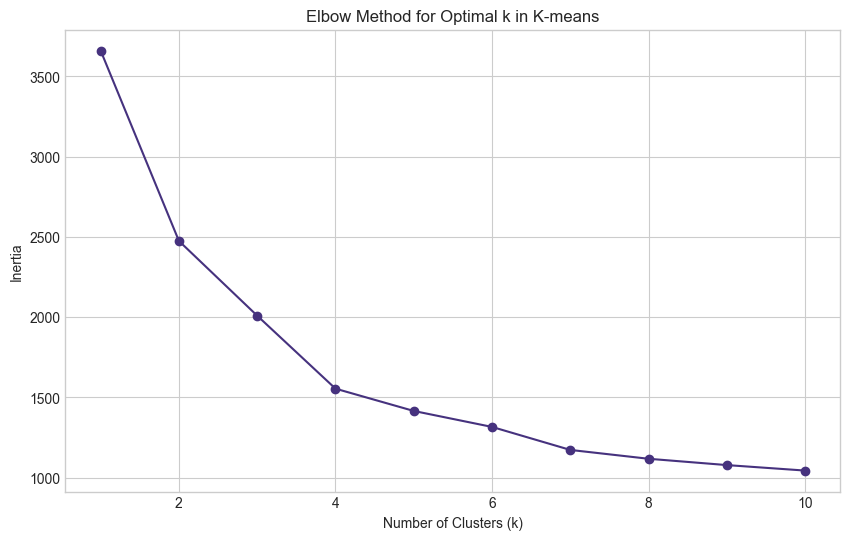

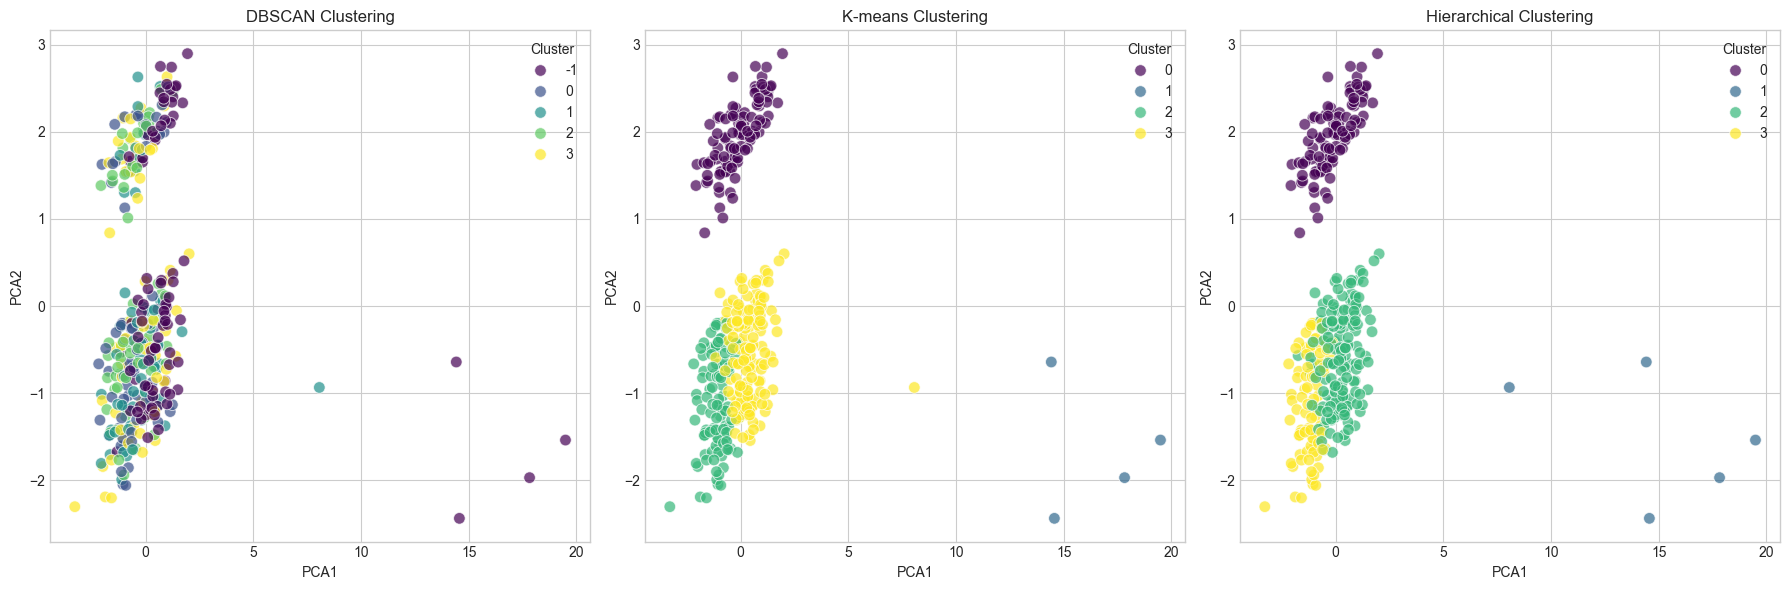

Silhouette Scores for Different Clustering Methods:
DBSCAN: -0.0293
K-means: 0.2291
Hierarchical: 0.2186

## Clustering Algorithm Comparison

### DBSCAN
**Advantages:**
- Does not require specifying number of clusters
- Can find arbitrarily shaped clusters
- Identifies outliers/noise points
- Robust to outliers

**Disadvantages:**
- Sensitive to parameter selection (eps and min_samples)
- Struggles with varying density clusters
- Can be computationally expensive for large datasets

### K-means
**Advantages:**
- Simple and easy to implement
- Scales well to large datasets
- Works well with globular clusters

**Disadvantages:**
- Requires specifying number of clusters beforehand
- Sensitive to outliers
- Only finds convex-shaped clusters
- Result depends on initial centroid positions

### Hierarchical Clustering
**Advantages:**
- Does not require specifying number of clusters
- Produces a dendrogram showing the hierarchy of clusters
- Can use different linkage criteria

**Disadvantages:*

In [30]:
# Compare DBSCAN with K-means and Hierarchical Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

# Determine optimal number of clusters for K-means using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k in K-means')
plt.grid(True)
plt.show()

# Choose optimal k (let's say it's 4 based on the elbow plot)
optimal_k = 4  # Adjust this based on the elbow plot

# Apply K-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Apply Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=optimal_k)
hc_labels = hc.fit_predict(X_scaled)

# Ensure all labels have the same length as the dataframe
if len(labels) != len(df):
    print(f"Warning: DBSCAN labels length ({len(labels)}) doesn't match DataFrame length ({len(df)})")
    # Pad with -1 (noise) if necessary
    if len(labels) < len(df):
        labels = np.pad(labels, (0, len(df) - len(labels)), constant_values=-1)
    else:
        labels = labels[:len(df)]
        
if len(kmeans_labels) != len(df):
    print(f"Warning: K-means labels length ({len(kmeans_labels)}) doesn't match DataFrame length ({len(df)})")
    if len(kmeans_labels) < len(df):
        kmeans_labels = np.pad(kmeans_labels, (0, len(df) - len(kmeans_labels)), constant_values=-1)
    else:
        kmeans_labels = kmeans_labels[:len(df)]
        
if len(hc_labels) != len(df):
    print(f"Warning: Hierarchical clustering labels length ({len(hc_labels)}) doesn't match DataFrame length ({len(df)})")
    if len(hc_labels) < len(df):
        hc_labels = np.pad(hc_labels, (0, len(df) - len(hc_labels)), constant_values=-1)
    else:
        hc_labels = hc_labels[:len(df)]

# Add labels to the dataframe for comparison
df['dbscan_cluster'] = labels  # Use labels instead of clusters
df['kmeans_cluster'] = kmeans_labels
df['hc_cluster'] = hc_labels

# Visualize the results of different algorithms using PCA
pca_compare = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'DBSCAN': df['dbscan_cluster'],
    'K-means': df['kmeans_cluster'],
    'Hierarchical': df['hc_cluster'],
    'Date': df['date']
})

# Create plots for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# DBSCAN
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN', 
                palette='viridis', data=pca_compare, 
                alpha=0.7, s=70, ax=axes[0])
axes[0].set_title('DBSCAN Clustering')
axes[0].legend(title='Cluster')

# K-means
sns.scatterplot(x='PCA1', y='PCA2', hue='K-means', 
                palette='viridis', data=pca_compare, 
                alpha=0.7, s=70, ax=axes[1])
axes[1].set_title('K-means Clustering')
axes[1].legend(title='Cluster')

# Hierarchical
sns.scatterplot(x='PCA1', y='PCA2', hue='Hierarchical', 
                palette='viridis', data=pca_compare, 
                alpha=0.7, s=70, ax=axes[2])
axes[2].set_title('Hierarchical Clustering')
axes[2].legend(title='Cluster')

plt.tight_layout()
plt.show()

# Compare clustering methods in terms of silhouette score
from sklearn.metrics import silhouette_score

# Filter out noise points for DBSCAN silhouette calculation
dbscan_data = X_scaled[labels != -1]
dbscan_labels = labels[labels != -1]

# Calculate silhouette scores
if len(set(dbscan_labels)) > 1:  # Ensure there are at least 2 clusters
    dbscan_silhouette = silhouette_score(dbscan_data, dbscan_labels)
else:
    dbscan_silhouette = np.nan

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
hc_silhouette = silhouette_score(X_scaled, hc_labels)

# Display results
print("Silhouette Scores for Different Clustering Methods:")
print(f"DBSCAN: {dbscan_silhouette:.4f}")
print(f"K-means: {kmeans_silhouette:.4f}")
print(f"Hierarchical: {hc_silhouette:.4f}")

# Compare algorithm advantages and disadvantages
print("""
## Clustering Algorithm Comparison

### DBSCAN
**Advantages:**
- Does not require specifying number of clusters
- Can find arbitrarily shaped clusters
- Identifies outliers/noise points
- Robust to outliers

**Disadvantages:**
- Sensitive to parameter selection (eps and min_samples)
- Struggles with varying density clusters
- Can be computationally expensive for large datasets

### K-means
**Advantages:**
- Simple and easy to implement
- Scales well to large datasets
- Works well with globular clusters

**Disadvantages:**
- Requires specifying number of clusters beforehand
- Sensitive to outliers
- Only finds convex-shaped clusters
- Result depends on initial centroid positions

### Hierarchical Clustering
**Advantages:**
- Does not require specifying number of clusters
- Produces a dendrogram showing the hierarchy of clusters
- Can use different linkage criteria

**Disadvantages:**
- Computationally expensive (O(n³) complexity)
- Cannot handle large datasets well
- Does not work well with noisy data

For our retail time series data, DBSCAN is particularly useful because:
1. It identifies outliers which correspond to special events and holidays
2. It can discover patterns without requiring us to specify the number of clusters
3. It can find clusters of varying shapes that better represent natural patterns in retail sales data
"""
)